# Sentiment Analysis on Extracted Forumns

**Import All Required Packages**

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
#import re
import string
from string import punctuation
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')


import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ricardo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**Read data from csv**

In [3]:
df = pd.read_csv('/Users/ricardo/Documents/ML/rotten_tomatoes_movies.csv')
df.head(1)

,rotten_tomatoes_link,movie_title,movie_info,critics_consensus,content_rating,genres,directors,authors,actors,original_release_date,...,production_company,tomatometer_status,tomatometer_rating,tomatometer_count,audience_status,audience_rating,audience_count,tomatometer_top_critics_count,tomatometer_fresh_critics_count,tomatometer_rotten_critics_count
0,m/0814255,Percy Jackson & the Olympians: The Lightning T...,"Always trouble-prone, the life of teenager Per...",Though it may seem like just another Harry Pot...,PG,"Action & Adventure, Comedy, Drama, Science Fic...",Chris Columbus,"Craig Titley, Chris Columbus, Rick Riordan","Logan Lerman, Brandon T. Jackson, Alexandra Da...",2010-02-12,...,20th Century Fox,Rotten,49.0,149.0,Spilled,53.0,254421.0,43,73,76


In [4]:
df.dropna(inplace=True)
df = df[:1000]

**Drop unnecessary columns**

In [5]:
df = df.drop(['rotten_tomatoes_link', 'movie_info',
             'content_rating','genres','directors','authors','actors',
             'original_release_date','production_company','tomatometer_status',
             'tomatometer_rating','tomatometer_count','audience_status',
             'tomatometer_top_critics_count','tomatometer_rotten_critics_count',
             'streaming_release_date', 'runtime', 'tomatometer_fresh_critics_count' ], axis=1)


**Calculation of Polarity**

In [6]:
df['Polarity_Rating'] = df['audience_rating'].apply(lambda x: 'Positive' if (x >= 60) else 'Neutral' if (x < 60 and x > 49) else 'Negative')

In [7]:
df.head()

,movie_title,critics_consensus,audience_rating,audience_count,Polarity_Rating
0,Percy Jackson & the Olympians: The Lightning T...,Though it may seem like just another Harry Pot...,53.0,254421.0,Neutral
1,Please Give,Nicole Holofcener's newest might seem slight i...,64.0,11574.0,Positive
2,10,Blake Edwards' bawdy comedy may not score a pe...,53.0,14684.0,Neutral
3,12 Angry Men (Twelve Angry Men),Sidney Lumet's feature debut is a superbly wri...,97.0,105386.0,Positive
4,"20,000 Leagues Under The Sea","One of Disney's finest live-action adventures,...",74.0,68918.0,Positive


In [8]:
df.shape

(1000, 5)

**Plot the Rating visualization graph**

<AxesSubplot:xlabel='audience_rating', ylabel='count'>

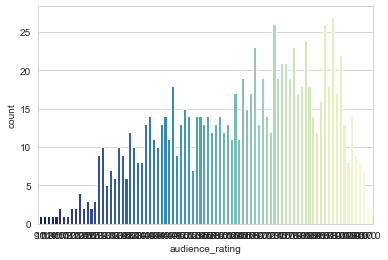

In [9]:
sns.set_style('whitegrid')
sns.countplot(x='audience_rating',data=df, palette='YlGnBu_r')

**Plot the Polarity Rating count**

<AxesSubplot:xlabel='Polarity_Rating', ylabel='count'>

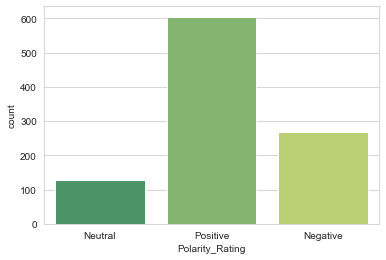

In [10]:
sns.set_style('whitegrid')
sns.countplot(x='Polarity_Rating',data=df, palette='summer')

**Data Preprocessing**

In [11]:
df_Positive = df[df['Polarity_Rating'] == 'Positive'][0:1000]
df_Neutral = df[df['Polarity_Rating'] == 'Neutral']
df_Negative = df[df['Polarity_Rating'] == 'Negative']

**Sample negative and neutral polarity dataset and create final dataframe**

In [12]:
df_Neutral_over = df_Neutral.sample(1000, replace=True)
df_Negative_over = df_Negative.sample(1000, replace=True)
df = pd.concat([df_Positive, df_Neutral_over, df_Negative_over], axis=0)

**Text Preprocessing**

In [13]:
def get_text_processing(text):
    stpword = stopwords.words('english')
    no_punctuation = [char for char in text if char not in string.punctuation]
    no_punctuation = ''.join(no_punctuation)
    return ' '.join([word for word in no_punctuation.split() if word.lower() not in stpword])

**Apply the method "get_text_processing" into column review text**

In [14]:
df['review'] = df['critics_consensus'].apply(get_text_processing)
df.head()

,movie_title,critics_consensus,audience_rating,audience_count,Polarity_Rating,review
1,Please Give,Nicole Holofcener's newest might seem slight i...,64.0,11574.0,Positive,Nicole Holofceners newest might seem slight pl...
3,12 Angry Men (Twelve Angry Men),Sidney Lumet's feature debut is a superbly wri...,97.0,105386.0,Positive,Sidney Lumets feature debut superbly written d...
4,"20,000 Leagues Under The Sea","One of Disney's finest live-action adventures,...",74.0,68918.0,Positive,One Disneys finest liveaction adventures 20000...
6,The 39 Steps,"Packed with twists and turns, this essential e...",86.0,23890.0,Positive,Packed twists turns essential early Alfred Hit...
12,The Lost City,"Its heart is in the right place, but what star...",64.0,25944.0,Positive,heart right place starts promising exercise de...


**Visualize Text Review with Polarity Rating**

In [15]:
df = df[['review', 'Polarity_Rating']]
df.head()

,review,Polarity_Rating
1,Nicole Holofceners newest might seem slight pl...,Positive
3,Sidney Lumets feature debut superbly written d...,Positive
4,One Disneys finest liveaction adventures 20000...,Positive
6,Packed twists turns essential early Alfred Hit...,Positive
12,heart right place starts promising exercise de...,Positive


In [16]:
df.shape

(2605, 2)

**Apply One hot encoding on negative, neutral, and positive**

In [17]:
one_hot = pd.get_dummies(df["Polarity_Rating"])
df.drop(['Polarity_Rating'],axis=1,inplace=True)
df = pd.concat([df,one_hot],axis=1)
df.head()

,review,Negative,Neutral,Positive
1,Nicole Holofceners newest might seem slight pl...,0,0,1
3,Sidney Lumets feature debut superbly written d...,0,0,1
4,One Disneys finest liveaction adventures 20000...,0,0,1
6,Packed twists turns essential early Alfred Hit...,0,0,1
12,heart right place starts promising exercise de...,0,0,1


**Apply Train Test Split**

In [18]:
X = df['review'].values
y = df.drop('review', axis=1).values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

**Apply vectorization**

In [19]:
vect = CountVectorizer()
X_train = vect.fit_transform(X_train)
X_test = vect.transform(X_test)

**Apply frequency, inverse document frequency:**

In [20]:
tfidf = TfidfTransformer()
X_train = tfidf.fit_transform(X_train)
X_test = tfidf.transform(X_test)
X_train = X_train.toarray()
X_test = X_test.toarray()

**Add different layers**

In [21]:
model = Sequential()

model.add(Dense(units=12673,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=4000,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=500,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=3, activation='softmax'))

opt=tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

2022-08-07 15:51:32.663629: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


**Fit the Model**

In [22]:
model.fit(x=X_train, y=y_train, batch_size=256, epochs=100, validation_data=(X_test, y_test), verbose=1, callbacks=early_stop)

Epoch 1/100
8/8 [==============================] - 9s 990ms/step - loss: 0.9780 - accuracy: 0.4937 - val_loss: 0.6613 - val_accuracy: 0.7136
Epoch 2/100
8/8 [==============================] - 8s 1s/step - loss: 0.2994 - accuracy: 0.8733 - val_loss: 0.1959 - val_accuracy: 0.9309
Epoch 3/100
8/8 [==============================] - 8s 1s/step - loss: 0.0313 - accuracy: 0.9940 - val_loss: 0.2536 - val_accuracy: 0.9604
Epoch 4/100
8/8 [==============================] - 9s 1s/step - loss: 6.4570e-04 - accuracy: 1.0000 - val_loss: 0.3286 - val_accuracy: 0.9565
Epoch 4: early stopping


**Evaluation of Model**

In [23]:
model_score = model.evaluate(X_test, y_test, batch_size=64, verbose=1)
print('Test accuracy:', model_score[1])

13/13 [==============================] - 1s 95ms/step - loss: 0.3286 - accuracy: 0.9565
Test accuracy: 0.95652174949646


**Prediction**

In [24]:
preds = model.predict(X_test)
preds

25/25 [==============================] - 2s 81ms/step


array([[3.5702598e-17, 9.9999917e-01, 8.5234291e-07],
       [4.8128084e-16, 9.9999988e-01, 1.3114904e-07],
       [3.4939632e-05, 6.5067360e-07, 9.9996436e-01],
       ...,
       [9.7058263e-18, 9.9999988e-01, 7.7264595e-08],
       [2.8277325e-02, 8.1921748e-08, 9.7172260e-01],
       [1.0000000e+00, 2.3198744e-18, 9.6453219e-09]], dtype=float32)

In [25]:
preds.shape

(782, 3)

In [26]:
preds

array([[3.5702598e-17, 9.9999917e-01, 8.5234291e-07],
       [4.8128084e-16, 9.9999988e-01, 1.3114904e-07],
       [3.4939632e-05, 6.5067360e-07, 9.9996436e-01],
       ...,
       [9.7058263e-18, 9.9999988e-01, 7.7264595e-08],
       [2.8277325e-02, 8.1921748e-08, 9.7172260e-01],
       [1.0000000e+00, 2.3198744e-18, 9.6453219e-09]], dtype=float32)